<a href="https://colab.research.google.com/github/jayanth142006/potato-disease-classification-models/blob/main/InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define input and output directories
input_dir = "/content/drive/MyDrive/potato_dis"
output_dir = "/content/drive/MyDrive/potato_dis_aug"
os.makedirs(output_dir, exist_ok=True)

# Augmentation strategy per class
augmentation_map = {
    "Pest": 1,
    "Phytopthora": 1,
    "Virus": 1,
    "Bacteria": 1,
    "Fungi": 1,
    "Nematode": 9,
    "Healthy": 2
}

# ImageDataGenerator settings
aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

print("[INFO] Starting augmentation process...")

# Loop through each class
for class_name, aug_count in augmentation_map.items():
    print(f"[INFO] Processing class '{class_name}' with {aug_count} augmentations per image")

    input_class_dir = os.path.join(input_dir, class_name)
    output_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    # Filter image files
    image_files = [f for f in os.listdir(input_class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    for img_name in image_files:
        img_path = os.path.join(input_class_dir, img_name)

        # Copy original image
        shutil.copy(img_path, os.path.join(output_class_dir, img_name))

        # Prepare for augmentation
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        gen = aug.flow(img_array, batch_size=1,
                       save_to_dir=output_class_dir,
                       save_prefix="aug",
                       save_format="jpg")

        # Save augmentations
        total = 0
        for _ in gen:
            total += 1
            if total >= aug_count:
                break

print("[INFO] ✅ All images and augmentations saved successfully.")


[INFO] Starting augmentation process...
[INFO] Processing class 'Pest' with 1 augmentations per image
[INFO] Processing class 'Phytopthora' with 1 augmentations per image
[INFO] Processing class 'Virus' with 1 augmentations per image
[INFO] Processing class 'Bacteria' with 1 augmentations per image
[INFO] Processing class 'Fungi' with 1 augmentations per image
[INFO] Processing class 'Nematode' with 9 augmentations per image
[INFO] Processing class 'Healthy' with 2 augmentations per image
[INFO] ✅ All images and augmentations saved successfully.


In [ ]:
import os

train_path = '/content/drive/MyDrive/potato_dis_aug'

# Get all class folders
class_names = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# Dictionary to store image counts
class_image_counts = {}

# Count images in each class folder
for cls in class_names:
    class_folder = os.path.join(train_path, cls)
    image_files = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
    class_image_counts[cls] = len(image_files)

# Display results
print(f"Total classes: {len(class_names)}\n")
for cls, count in class_image_counts.items():
    print(f"{cls}: {count} images")


Total classes: 7

Pest: 1205 images
Phytopthora: 685 images
Virus: 1072 images
Bacteria: 1120 images
Fungi: 1470 images
Nematode: 665 images
Healthy: 598 images


In [ ]:
train_path = '/content/drive/MyDrive/potato_dis_aug'
img_size = (299, 299)
batch_size = 32
num_classes = 7 # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5453 images belonging to 7 classes.
Found 1362 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze Initial Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2348s 14s/step - accuracy: 0.2295 - loss: 1.9220 - val_accuracy: 0.3752 - val_loss: 1.5898
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.3578 - loss: 1.5784 - val_accuracy: 0.4868 - val_loss: 1.3297
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.4029 - loss: 1.4657 - val_accuracy: 0.4288 - val_loss: 1.3877
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4445 - loss: 1.4113 - val_accuracy: 0.5029 - val_loss: 1.2820
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.4712 - loss: 1.3515 - val_accuracy: 0.4765 - val_loss: 1.3264
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.4721 - loss: 1.3531 - val_accuracy: 0.5044 - val_loss: 1.2500
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.4979 - loss: 1.2897 - val_accuracy: 0.5617 - val_loss: 1.1916
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4932 - loss: 1.2925 - val_ac

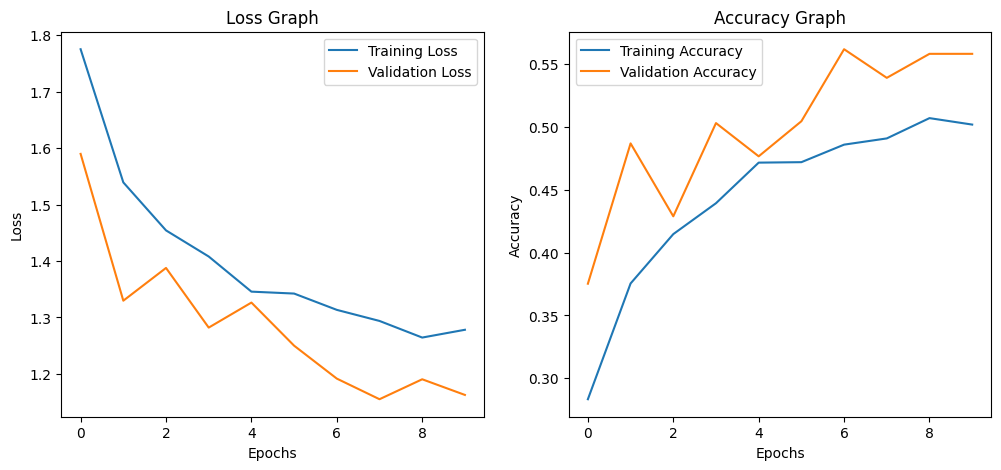

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 816ms/step
Before Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.90      0.74      0.81       224
       Fungi       0.56      0.38      0.45       294
     Healthy       0.34      0.77      0.47       119
    Nematode       0.88      0.68      0.77       133
        Pest       0.40      0.20      0.27       241
 Phytopthora       0.48      0.58      0.53       137
       Virus       0.46      0.68      0.55       214

    accuracy                           0.54      1362
   macro avg       0.57      0.58      0.55      1362
weighted avg       0.58      0.54      0.53      1362



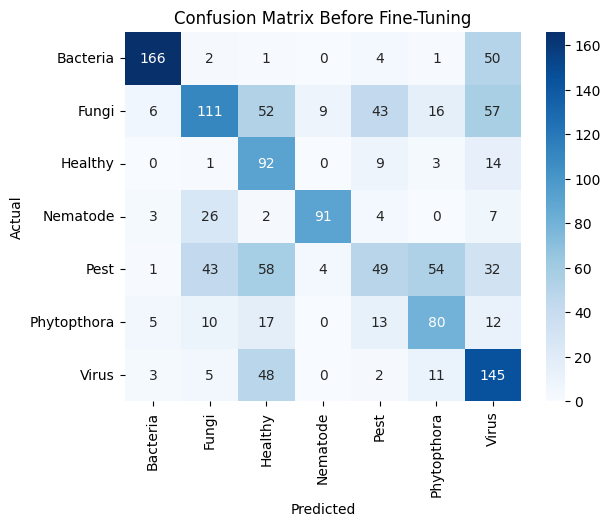

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:682]:
    layer.trainable = False
for layer in base_model.layers[682:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9320 - loss: 0.2164 - val_accuracy: 0.9075 - val_loss: 0.2736
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9254 - loss: 0.2480 - val_accuracy: 0.9097 - val_loss: 0.2421
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9362 - loss: 0.2148 - val_accuracy: 0.9398 - val_loss: 0.2062
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9401 - loss: 0.1851 - val_accuracy: 0.9148 - val_loss: 0.2917
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9445 - loss: 0.1785 - val_accuracy: 0.9075 - val_loss: 0.3128
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9468 - loss: 0.1663 - val_accuracy: 0.9258 - val_loss: 0.2363
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9535 - loss: 0.1540 - val_accuracy: 0.9325 - val_loss: 0.2159
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9601 - loss: 0.1343 - val_accu

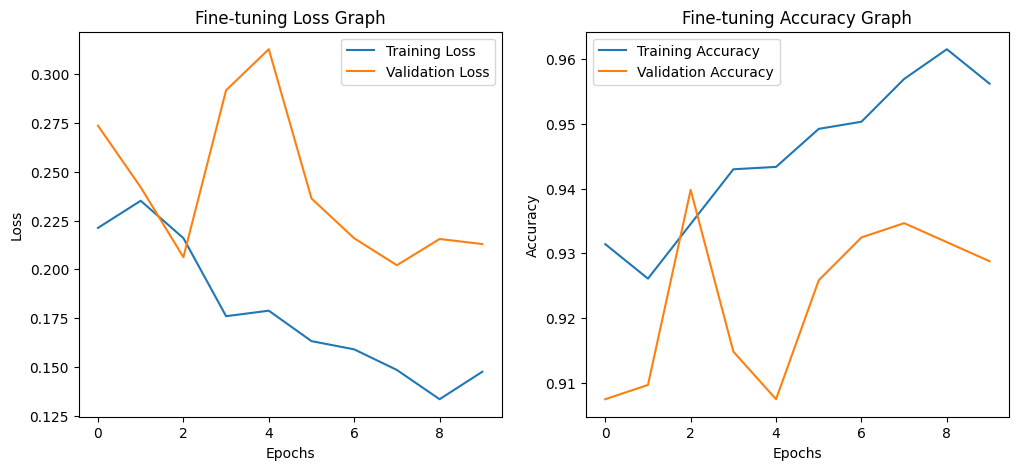

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 526ms/step
After Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       0.98      0.99      0.99       224
       Fungi       0.90      0.93      0.91       294
     Healthy       0.87      0.99      0.93       119
    Nematode       0.99      0.99      0.99       133
        Pest       0.91      0.84      0.88       241
 Phytopthora       0.92      0.96      0.94       137
       Virus       0.97      0.91      0.94       214

    accuracy                           0.93      1362
   macro avg       0.94      0.94      0.94      1362
weighted avg       0.94      0.93      0.93      1362



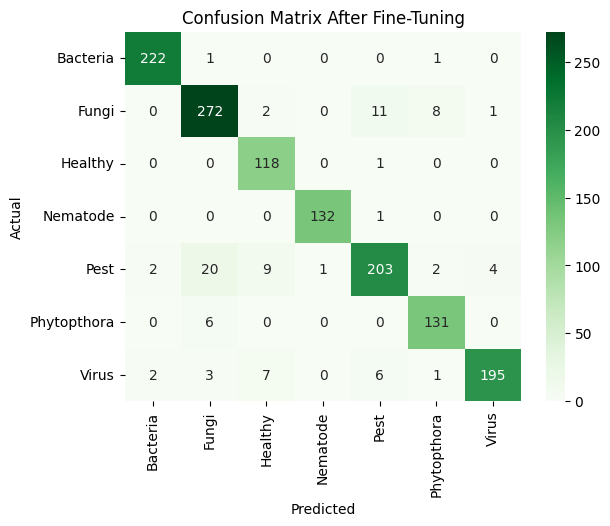

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()

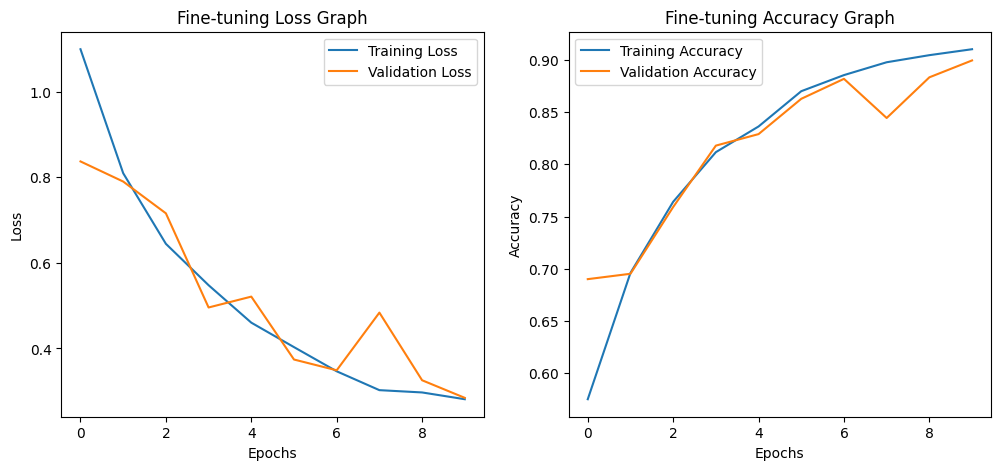

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 829ms/step
After Fine-Tuning:
              precision    recall  f1-score   support

    Bacteria       1.00      0.93      0.97       224
       Fungi       0.89      0.90      0.90       294
     Healthy       0.76      0.98      0.86       119
    Nematode       0.99      0.99      0.99       133
        Pest       0.84      0.79      0.81       241
 Phytopthora       0.94      0.82      0.88       137
       Virus       0.90      0.93      0.91       214

    accuracy                           0.90      1362
   macro avg       0.90      0.91      0.90      1362
weighted avg       0.90      0.90      0.90      1362



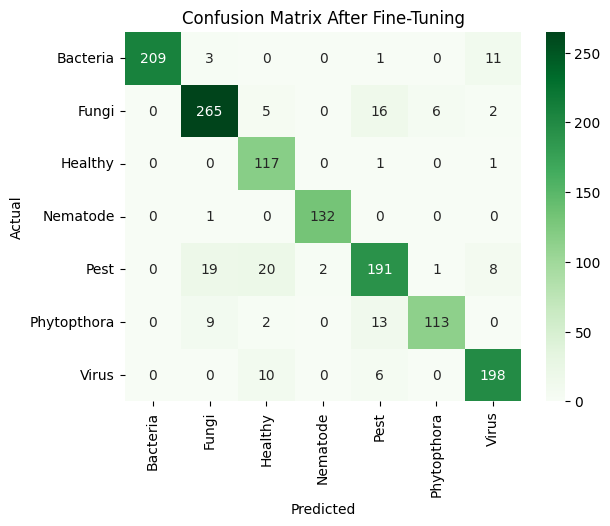

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()